# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (SentiWS) most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, SentiWS (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11783
EM converged at iteration 62, llf=-11538, convergence criterion=9.8762e-07 < tolerance=1e-06
EM start iterations, llf=-11796
EM converged at iteration 62, llf=-11550, convergence criterion=9.866e-07 < tolerance=1e-06
EM start iterations, llf=-11849
EM converged at iteration 62, llf=-11600, convergence criterion=9.8927e-07 < tolerance=1e-06
EM start iterations, llf=-11855
EM converged at iteration 62, llf=-11607, convergence criterion=9.8904e-07 < tolerance=1e-06
EM start iterations, llf=-11918
EM converged at iteration 62, llf=-11665, convergence criterion=9.9305e-07 < tolerance=1e-06
EM start iterations, llf=-11926
EM converged at iteration 62, llf=-11672, convergence criterion=9.9041e-07 < tolerance=1e-06
EM start iterations, llf=-11981
EM converged at iteration 62, llf=-11727, convergence criterion=9.8972e-07 < tolerance=1e-06
EM start iterations, llf=-11981
EM converged at iteration 62, llf=-11727, convergence criterion=9.8972e-07 < tolerance=1e-06
E

EM start iterations, llf=-13532
EM converged at iteration 53, llf=-13334, convergence criterion=9.9336e-07 < tolerance=1e-06
EM start iterations, llf=-13592
EM converged at iteration 52, llf=-13405, convergence criterion=9.772e-07 < tolerance=1e-06
EM start iterations, llf=-13598
EM converged at iteration 52, llf=-13408, convergence criterion=9.7906e-07 < tolerance=1e-06
EM start iterations, llf=-13650
EM converged at iteration 52, llf=-13455, convergence criterion=9.766e-07 < tolerance=1e-06
EM start iterations, llf=-13650
EM converged at iteration 52, llf=-13455, convergence criterion=9.766e-07 < tolerance=1e-06
EM start iterations, llf=-13662
EM converged at iteration 52, llf=-13468, convergence criterion=9.8215e-07 < tolerance=1e-06
EM start iterations, llf=-13712
EM converged at iteration 52, llf=-13521, convergence criterion=9.7466e-07 < tolerance=1e-06
EM start iterations, llf=-13717
EM converged at iteration 52, llf=-13525, convergence criterion=9.7492e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-15278
EM converged at iteration 54, llf=-15069, convergence criterion=9.9784e-07 < tolerance=1e-06
EM start iterations, llf=-15278
EM converged at iteration 54, llf=-15069, convergence criterion=9.9784e-07 < tolerance=1e-06
EM start iterations, llf=-15288
EM converged at iteration 54, llf=-15079, convergence criterion=9.9714e-07 < tolerance=1e-06
EM start iterations, llf=-15342
EM converged at iteration 54, llf=-15133, convergence criterion=9.9619e-07 < tolerance=1e-06
EM start iterations, llf=-15353
EM converged at iteration 54, llf=-15144, convergence criterion=9.9408e-07 < tolerance=1e-06
EM start iterations, llf=-15402
EM converged at iteration 54, llf=-15192, convergence criterion=9.9796e-07 < tolerance=1e-06
EM start iterations, llf=-15410
EM converged at iteration 54, llf=-15199, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-15455
EM converged at iteration 54, llf=-15244, convergence criterion=9.9231e-07 < tolerance=1e-06


EM start iterations, llf=-16986
EM converged at iteration 62, llf=-16743, convergence criterion=9.7241e-07 < tolerance=1e-06
EM start iterations, llf=-16991
EM converged at iteration 62, llf=-16748, convergence criterion=9.7227e-07 < tolerance=1e-06
EM start iterations, llf=-17045
EM converged at iteration 62, llf=-16802, convergence criterion=9.8098e-07 < tolerance=1e-06
EM start iterations, llf=-17052
EM converged at iteration 62, llf=-16808, convergence criterion=9.8113e-07 < tolerance=1e-06
EM start iterations, llf=-17108
EM converged at iteration 62, llf=-16865, convergence criterion=9.8231e-07 < tolerance=1e-06
EM start iterations, llf=-17108
EM converged at iteration 62, llf=-16865, convergence criterion=9.8231e-07 < tolerance=1e-06
EM start iterations, llf=-17117
EM converged at iteration 62, llf=-16875, convergence criterion=9.8074e-07 < tolerance=1e-06
EM start iterations, llf=-17169
EM converged at iteration 62, llf=-16927, convergence criterion=9.7764e-07 < tolerance=1e-06


EM start iterations, llf=-18514
EM converged at iteration 63, llf=-18258, convergence criterion=9.7571e-07 < tolerance=1e-06
EM start iterations, llf=-18573
EM converged at iteration 63, llf=-18316, convergence criterion=9.7014e-07 < tolerance=1e-06
EM start iterations, llf=-18573
EM converged at iteration 63, llf=-18316, convergence criterion=9.7014e-07 < tolerance=1e-06
EM start iterations, llf=-18579
EM converged at iteration 63, llf=-18322, convergence criterion=9.7e-07 < tolerance=1e-06
EM start iterations, llf=-18632
EM converged at iteration 62, llf=-18374, convergence criterion=9.9857e-07 < tolerance=1e-06
EM start iterations, llf=-18639
EM converged at iteration 62, llf=-18381, convergence criterion=9.9804e-07 < tolerance=1e-06
EM start iterations, llf=-18697
EM converged at iteration 62, llf=-18438, convergence criterion=9.9609e-07 < tolerance=1e-06
EM start iterations, llf=-18705
EM converged at iteration 62, llf=-18445, convergence criterion=9.9587e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-12335
EM converged at iteration 64, llf=-12065, convergence criterion=9.9378e-07 < tolerance=1e-06
EM start iterations, llf=-12318
EM converged at iteration 64, llf=-12045, convergence criterion=9.9574e-07 < tolerance=1e-06
EM start iterations, llf=-12378
EM converged at iteration 64, llf=-12119, convergence criterion=9.9123e-07 < tolerance=1e-06
EM start iterations, llf=-12397
EM converged at iteration 64, llf=-12144, convergence criterion=9.8383e-07 < tolerance=1e-06
EM start iterations, llf=-12462
EM converged at iteration 64, llf=-12229, convergence criterion=9.8329e-07 < tolerance=1e-06
EM start iterations, llf=-12461
EM converged at iteration 64, llf=-12226, convergence criterion=9.81e-07 < tolerance=1e-06
EM start iterations, llf=-12483
EM converged at iteration 62, llf=-12256, convergence criterion=9.9115e-07 < tolerance=1e-06
EM start iterations, llf=-12483
EM converged at iteration 62, llf=-12256, convergence criterion=9.9115e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14081
EM converged at iteration 59, llf=-13874, convergence criterion=9.6514e-07 < tolerance=1e-06
EM start iterations, llf=-14121
EM converged at iteration 58, llf=-13906, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-14126
EM converged at iteration 59, llf=-13918, convergence criterion=9.8202e-07 < tolerance=1e-06
EM start iterations, llf=-14179
EM converged at iteration 61, llf=-13979, convergence criterion=9.7278e-07 < tolerance=1e-06
EM start iterations, llf=-14179
EM converged at iteration 61, llf=-13979, convergence criterion=9.7278e-07 < tolerance=1e-06
EM start iterations, llf=-14189
EM converged at iteration 61, llf=-13990, convergence criterion=9.7564e-07 < tolerance=1e-06
EM start iterations, llf=-14238
EM converged at iteration 61, llf=-14038, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-14246
EM converged at iteration 61, llf=-14044, convergence criterion=9.6559e-07 < tolerance=1e-06


EM start iterations, llf=-15830
EM converged at iteration 59, llf=-15608, convergence criterion=9.8835e-07 < tolerance=1e-06
EM start iterations, llf=-15830
EM converged at iteration 59, llf=-15608, convergence criterion=9.8835e-07 < tolerance=1e-06
EM start iterations, llf=-15838
EM converged at iteration 59, llf=-15615, convergence criterion=9.7716e-07 < tolerance=1e-06
EM start iterations, llf=-15889
EM converged at iteration 59, llf=-15665, convergence criterion=9.8497e-07 < tolerance=1e-06
EM start iterations, llf=-15891
EM converged at iteration 59, llf=-15666, convergence criterion=9.8696e-07 < tolerance=1e-06
EM start iterations, llf=-15947
EM converged at iteration 59, llf=-15721, convergence criterion=9.8973e-07 < tolerance=1e-06
EM start iterations, llf=-15952
EM converged at iteration 59, llf=-15725, convergence criterion=9.881e-07 < tolerance=1e-06
EM start iterations, llf=-15997
EM converged at iteration 59, llf=-15771, convergence criterion=9.9585e-07 < tolerance=1e-06
E

EM start iterations, llf=-17544
EM converged at iteration 65, llf=-17305, convergence criterion=9.9415e-07 < tolerance=1e-06
EM start iterations, llf=-17549
EM converged at iteration 65, llf=-17310, convergence criterion=9.933e-07 < tolerance=1e-06
EM start iterations, llf=-17604
EM converged at iteration 65, llf=-17363, convergence criterion=9.9607e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 65, llf=-17370, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-17660
EM converged at iteration 65, llf=-17418, convergence criterion=9.9051e-07 < tolerance=1e-06
EM start iterations, llf=-17660
EM converged at iteration 65, llf=-17418, convergence criterion=9.9051e-07 < tolerance=1e-06
EM start iterations, llf=-17679
EM converged at iteration 65, llf=-17437, convergence criterion=9.9039e-07 < tolerance=1e-06
EM start iterations, llf=-17732
EM converged at iteration 65, llf=-17490, convergence criterion=9.8514e-07 < tolerance=1e-06
E

EM start iterations, llf=-19060
EM converged at iteration 65, llf=-18791, convergence criterion=9.7958e-07 < tolerance=1e-06
EM start iterations, llf=-19110
EM converged at iteration 65, llf=-18842, convergence criterion=9.7447e-07 < tolerance=1e-06
EM start iterations, llf=-19110
EM converged at iteration 65, llf=-18842, convergence criterion=9.7447e-07 < tolerance=1e-06
EM start iterations, llf=-19118
EM converged at iteration 65, llf=-18851, convergence criterion=9.753e-07 < tolerance=1e-06
EM start iterations, llf=-19177
EM converged at iteration 65, llf=-18909, convergence criterion=9.7897e-07 < tolerance=1e-06
EM start iterations, llf=-19184
EM converged at iteration 65, llf=-18917, convergence criterion=9.7811e-07 < tolerance=1e-06
EM start iterations, llf=-19238
EM converged at iteration 65, llf=-18969, convergence criterion=9.6884e-07 < tolerance=1e-06
EM start iterations, llf=-19246
EM converged at iteration 65, llf=-18977, convergence criterion=9.6759e-07 < tolerance=1e-06
E

EM converged at iteration 65, llf=-12630, convergence criterion=9.9092e-07 < tolerance=1e-06
EM start iterations, llf=-12854
EM converged at iteration 65, llf=-12637, convergence criterion=9.9005e-07 < tolerance=1e-06
EM start iterations, llf=-12904
EM converged at iteration 65, llf=-12685, convergence criterion=9.8148e-07 < tolerance=1e-06
EM start iterations, llf=-12911
EM converged at iteration 65, llf=-12692, convergence criterion=9.8221e-07 < tolerance=1e-06
EM start iterations, llf=-12955
EM converged at iteration 63, llf=-12730, convergence criterion=9.8774e-07 < tolerance=1e-06
EM start iterations, llf=-12965
EM converged at iteration 63, llf=-12740, convergence criterion=9.8277e-07 < tolerance=1e-06
EM start iterations, llf=-13026
EM converged at iteration 64, llf=-12809, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-13026
EM converged at iteration 64, llf=-12809, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-13037


EM start iterations, llf=-14602
EM converged at iteration 65, llf=-14399, convergence criterion=9.7028e-07 < tolerance=1e-06
EM start iterations, llf=-14663
EM converged at iteration 65, llf=-14464, convergence criterion=9.8844e-07 < tolerance=1e-06
EM start iterations, llf=-14671
EM converged at iteration 65, llf=-14469, convergence criterion=9.7808e-07 < tolerance=1e-06
EM start iterations, llf=-14726
EM converged at iteration 65, llf=-14525, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-14726
EM converged at iteration 65, llf=-14525, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-14734
EM converged at iteration 65, llf=-14532, convergence criterion=9.7728e-07 < tolerance=1e-06
EM start iterations, llf=-14789
EM converged at iteration 65, llf=-14586, convergence criterion=9.7171e-07 < tolerance=1e-06
EM start iterations, llf=-14798
EM converged at iteration 64, llf=-14593, convergence criterion=9.9139e-07 < tolerance=1e-06


EM start iterations, llf=-16372
EM converged at iteration 65, llf=-16146, convergence criterion=9.9039e-07 < tolerance=1e-06
EM start iterations, llf=-16372
EM converged at iteration 65, llf=-16146, convergence criterion=9.9039e-07 < tolerance=1e-06
EM start iterations, llf=-16381
EM converged at iteration 65, llf=-16154, convergence criterion=9.8842e-07 < tolerance=1e-06
EM start iterations, llf=-16433
EM converged at iteration 64, llf=-16206, convergence criterion=9.9753e-07 < tolerance=1e-06
EM start iterations, llf=-16442
EM converged at iteration 64, llf=-16215, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-16492
EM converged at iteration 64, llf=-16264, convergence criterion=9.8641e-07 < tolerance=1e-06
EM start iterations, llf=-16500
EM converged at iteration 64, llf=-16271, convergence criterion=9.8397e-07 < tolerance=1e-06
EM start iterations, llf=-16552
EM converged at iteration 63, llf=-16323, convergence criterion=9.9584e-07 < tolerance=1e-06


EM start iterations, llf=-18079
EM converged at iteration 70, llf=-17833, convergence criterion=9.8021e-07 < tolerance=1e-06
EM start iterations, llf=-18085
EM converged at iteration 70, llf=-17840, convergence criterion=9.8092e-07 < tolerance=1e-06
EM start iterations, llf=-18140
EM converged at iteration 71, llf=-17893, convergence criterion=9.7574e-07 < tolerance=1e-06
EM start iterations, llf=-18147
EM converged at iteration 71, llf=-17900, convergence criterion=9.7526e-07 < tolerance=1e-06
EM start iterations, llf=-18203
EM converged at iteration 70, llf=-17955, convergence criterion=9.7765e-07 < tolerance=1e-06
EM start iterations, llf=-18203
EM converged at iteration 70, llf=-17955, convergence criterion=9.7765e-07 < tolerance=1e-06
EM start iterations, llf=-18207
EM converged at iteration 70, llf=-17958, convergence criterion=9.7552e-07 < tolerance=1e-06
EM start iterations, llf=-18259
EM converged at iteration 70, llf=-18008, convergence criterion=9.7297e-07 < tolerance=1e-06


EM start iterations, llf=-19320
EM converged at iteration 71, llf=-19046, convergence criterion=9.9797e-07 < tolerance=1e-06
EM start iterations, llf=-19376
EM converged at iteration 72, llf=-19102, convergence criterion=9.7286e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:25:08.519169.
EM start iterations, llf=-11307
EM converged at iteration 61, llf=-11162, convergence criterion=9.9096e-07 < tolerance=1e-06
EM start iterations, llf=-11320
EM converged at iteration 61, llf=-11175, convergence criterion=9.919e-07 < tolerance=1e-06
EM start iterations, llf=-11372
EM converged at iteration 61, llf=-11226, convergence criterion=9.8592e-07 < tolerance=1e-06
EM start iterations, llf=-11380
EM converged at iteration 61, llf=-11234, convergence criterion=9.8453e-07 < tolerance=1e-06
EM start iterations, llf=-11436
EM converged at iteration 60, llf=-11291, convergence criterion=9.7045e-07 < tolerance=1e-06
EM start iterations, llf=-11446
EM converged at 

EM start iterations, llf=-12817
EM converged at iteration 55, llf=-12667, convergence criterion=9.7053e-07 < tolerance=1e-06
EM start iterations, llf=-12830
EM converged at iteration 55, llf=-12679, convergence criterion=9.7183e-07 < tolerance=1e-06
EM start iterations, llf=-12866
EM converged at iteration 55, llf=-12714, convergence criterion=9.679e-07 < tolerance=1e-06
EM start iterations, llf=-12873
EM converged at iteration 55, llf=-12718, convergence criterion=9.6915e-07 < tolerance=1e-06
EM start iterations, llf=-12930
EM converged at iteration 53, llf=-12769, convergence criterion=9.9855e-07 < tolerance=1e-06
EM start iterations, llf=-12934
EM converged at iteration 53, llf=-12776, convergence criterion=9.9619e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 53, llf=-12818, convergence criterion=9.7892e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 53, llf=-12818, convergence criterion=9.7892e-07 < tolerance=1e-06
E

EM start iterations, llf=-14442
EM converged at iteration 52, llf=-14278, convergence criterion=9.6325e-07 < tolerance=1e-06
EM start iterations, llf=-14495
EM converged at iteration 54, llf=-14332, convergence criterion=9.7668e-07 < tolerance=1e-06
EM start iterations, llf=-14503
EM converged at iteration 54, llf=-14339, convergence criterion=9.7661e-07 < tolerance=1e-06
EM start iterations, llf=-14552
EM converged at iteration 54, llf=-14389, convergence criterion=9.6909e-07 < tolerance=1e-06
EM start iterations, llf=-14552
EM converged at iteration 54, llf=-14389, convergence criterion=9.6909e-07 < tolerance=1e-06
EM start iterations, llf=-14560
EM converged at iteration 54, llf=-14397, convergence criterion=9.6995e-07 < tolerance=1e-06
EM start iterations, llf=-14612
EM converged at iteration 54, llf=-14448, convergence criterion=9.674e-07 < tolerance=1e-06
EM start iterations, llf=-14618
EM converged at iteration 54, llf=-14455, convergence criterion=9.6747e-07 < tolerance=1e-06
E

EM start iterations, llf=-16134
EM converged at iteration 62, llf=-15961, convergence criterion=9.7201e-07 < tolerance=1e-06
EM start iterations, llf=-16134
EM converged at iteration 62, llf=-15961, convergence criterion=9.7201e-07 < tolerance=1e-06
EM start iterations, llf=-16148
EM converged at iteration 62, llf=-15975, convergence criterion=9.7028e-07 < tolerance=1e-06
EM start iterations, llf=-16204
EM converged at iteration 62, llf=-16033, convergence criterion=9.7198e-07 < tolerance=1e-06
EM start iterations, llf=-16207
EM converged at iteration 62, llf=-16035, convergence criterion=9.7396e-07 < tolerance=1e-06
EM start iterations, llf=-16260
EM converged at iteration 62, llf=-16088, convergence criterion=9.7974e-07 < tolerance=1e-06
EM start iterations, llf=-16267
EM converged at iteration 62, llf=-16095, convergence criterion=9.7917e-07 < tolerance=1e-06
EM start iterations, llf=-16320
EM converged at iteration 62, llf=-16148, convergence criterion=9.8354e-07 < tolerance=1e-06


EM start iterations, llf=-17589
EM converged at iteration 63, llf=-17411, convergence criterion=9.9351e-07 < tolerance=1e-06
EM start iterations, llf=-17603
EM converged at iteration 63, llf=-17424, convergence criterion=9.9154e-07 < tolerance=1e-06
EM start iterations, llf=-17660
EM converged at iteration 63, llf=-17480, convergence criterion=9.8869e-07 < tolerance=1e-06
EM start iterations, llf=-17665
EM converged at iteration 63, llf=-17486, convergence criterion=9.8801e-07 < tolerance=1e-06
EM start iterations, llf=-17722
EM converged at iteration 63, llf=-17543, convergence criterion=9.8122e-07 < tolerance=1e-06
EM start iterations, llf=-17722
EM converged at iteration 63, llf=-17543, convergence criterion=9.8122e-07 < tolerance=1e-06
EM start iterations, llf=-17727
EM converged at iteration 63, llf=-17548, convergence criterion=9.8131e-07 < tolerance=1e-06
EM start iterations, llf=-17777
EM converged at iteration 63, llf=-17597, convergence criterion=9.7625e-07 < tolerance=1e-06


EM start iterations, llf=-11756
EM converged at iteration 73, llf=-11606, convergence criterion=9.8595e-07 < tolerance=1e-06
EM start iterations, llf=-11759
EM converged at iteration 72, llf=-11608, convergence criterion=9.8501e-07 < tolerance=1e-06
EM start iterations, llf=-11825
EM converged at iteration 68, llf=-11675, convergence criterion=9.9254e-07 < tolerance=1e-06
EM start iterations, llf=-11825
EM converged at iteration 68, llf=-11675, convergence criterion=9.9254e-07 < tolerance=1e-06
EM start iterations, llf=-11836
EM converged at iteration 69, llf=-11688, convergence criterion=9.9151e-07 < tolerance=1e-06
EM start iterations, llf=-11909
EM converged at iteration 68, llf=-11767, convergence criterion=9.964e-07 < tolerance=1e-06
EM start iterations, llf=-11896
EM converged at iteration 68, llf=-11752, convergence criterion=9.8339e-07 < tolerance=1e-06
EM start iterations, llf=-11916
EM converged at iteration 67, llf=-11764, convergence criterion=9.8386e-07 < tolerance=1e-06
E

EM start iterations, llf=-13324
EM converged at iteration 61, llf=-13161, convergence criterion=9.8651e-07 < tolerance=1e-06
EM start iterations, llf=-13333
EM converged at iteration 61, llf=-13172, convergence criterion=9.7553e-07 < tolerance=1e-06
EM start iterations, llf=-13381
EM converged at iteration 61, llf=-13219, convergence criterion=9.9124e-07 < tolerance=1e-06
EM start iterations, llf=-13389
EM converged at iteration 61, llf=-13227, convergence criterion=9.9041e-07 < tolerance=1e-06
EM start iterations, llf=-13436
EM converged at iteration 62, llf=-13273, convergence criterion=9.7355e-07 < tolerance=1e-06
EM start iterations, llf=-13428
EM converged at iteration 62, llf=-13269, convergence criterion=9.6894e-07 < tolerance=1e-06
EM start iterations, llf=-13476
EM converged at iteration 62, llf=-13316, convergence criterion=9.8072e-07 < tolerance=1e-06
EM start iterations, llf=-13476
EM converged at iteration 62, llf=-13316, convergence criterion=9.8072e-07 < tolerance=1e-06


EM start iterations, llf=-14968
EM converged at iteration 59, llf=-14805, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-15020
EM converged at iteration 58, llf=-14857, convergence criterion=9.915e-07 < tolerance=1e-06
EM start iterations, llf=-15027
EM converged at iteration 58, llf=-14864, convergence criterion=9.965e-07 < tolerance=1e-06
EM start iterations, llf=-15074
EM converged at iteration 58, llf=-14913, convergence criterion=9.9571e-07 < tolerance=1e-06
EM start iterations, llf=-15074
EM converged at iteration 58, llf=-14913, convergence criterion=9.9571e-07 < tolerance=1e-06
EM start iterations, llf=-15086
EM converged at iteration 58, llf=-14924, convergence criterion=9.9614e-07 < tolerance=1e-06
EM start iterations, llf=-15139
EM converged at iteration 59, llf=-14976, convergence criterion=9.719e-07 < tolerance=1e-06
EM start iterations, llf=-15138
EM converged at iteration 59, llf=-14976, convergence criterion=9.6617e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16662
EM converged at iteration 66, llf=-16488, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-16662
EM converged at iteration 66, llf=-16488, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-16672
EM converged at iteration 66, llf=-16496, convergence criterion=9.8576e-07 < tolerance=1e-06
EM start iterations, llf=-16721
EM converged at iteration 66, llf=-16544, convergence criterion=9.8419e-07 < tolerance=1e-06
EM start iterations, llf=-16725
EM converged at iteration 66, llf=-16549, convergence criterion=9.8418e-07 < tolerance=1e-06
EM start iterations, llf=-16779
EM converged at iteration 66, llf=-16603, convergence criterion=9.9917e-07 < tolerance=1e-06
EM start iterations, llf=-16788
EM converged at iteration 66, llf=-16613, convergence criterion=9.9831e-07 < tolerance=1e-06
EM start iterations, llf=-16833
EM converged at iteration 67, llf=-16657, convergence criterion=9.7072e-07 < tolerance=1e-06


EM start iterations, llf=-18121
EM converged at iteration 66, llf=-17941, convergence criterion=9.8629e-07 < tolerance=1e-06
EM start iterations, llf=-18129
EM converged at iteration 66, llf=-17948, convergence criterion=9.8482e-07 < tolerance=1e-06
EM start iterations, llf=-18176
EM converged at iteration 66, llf=-17996, convergence criterion=9.8556e-07 < tolerance=1e-06
EM start iterations, llf=-18184
EM converged at iteration 66, llf=-18003, convergence criterion=9.8218e-07 < tolerance=1e-06
EM start iterations, llf=-18229
EM converged at iteration 66, llf=-18048, convergence criterion=9.7881e-07 < tolerance=1e-06
EM start iterations, llf=-18229
EM converged at iteration 66, llf=-18048, convergence criterion=9.7881e-07 < tolerance=1e-06
EM start iterations, llf=-18234
EM converged at iteration 66, llf=-18053, convergence criterion=9.8043e-07 < tolerance=1e-06
EM start iterations, llf=-18292
EM converged at iteration 66, llf=-18109, convergence criterion=9.8056e-07 < tolerance=1e-06


EM converged at iteration 77, llf=-12046, convergence criterion=9.8244e-07 < tolerance=1e-06
EM start iterations, llf=-12216
EM converged at iteration 76, llf=-12058, convergence criterion=9.8094e-07 < tolerance=1e-06
EM start iterations, llf=-12265
EM converged at iteration 74, llf=-12107, convergence criterion=9.9763e-07 < tolerance=1e-06
EM start iterations, llf=-12265
EM converged at iteration 74, llf=-12107, convergence criterion=9.9763e-07 < tolerance=1e-06
EM start iterations, llf=-12266
EM converged at iteration 77, llf=-12110, convergence criterion=9.7922e-07 < tolerance=1e-06
EM start iterations, llf=-12306
EM converged at iteration 78, llf=-12153, convergence criterion=9.9564e-07 < tolerance=1e-06
EM start iterations, llf=-12317
EM converged at iteration 77, llf=-12163, convergence criterion=9.9171e-07 < tolerance=1e-06
EM start iterations, llf=-12362
EM converged at iteration 78, llf=-12210, convergence criterion=9.8747e-07 < tolerance=1e-06
EM start iterations, llf=-12377


EM start iterations, llf=-13818
EM converged at iteration 73, llf=-13658, convergence criterion=9.9037e-07 < tolerance=1e-06
EM start iterations, llf=-13825
EM converged at iteration 73, llf=-13664, convergence criterion=9.958e-07 < tolerance=1e-06
EM start iterations, llf=-13886
EM converged at iteration 72, llf=-13725, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-13891
EM converged at iteration 72, llf=-13731, convergence criterion=9.8895e-07 < tolerance=1e-06
EM start iterations, llf=-13948
EM converged at iteration 72, llf=-13788, convergence criterion=9.8925e-07 < tolerance=1e-06
EM start iterations, llf=-13957
EM converged at iteration 72, llf=-13797, convergence criterion=9.7493e-07 < tolerance=1e-06
EM start iterations, llf=-14011
EM converged at iteration 70, llf=-13849, convergence criterion=9.9862e-07 < tolerance=1e-06
EM start iterations, llf=-14011
EM converged at iteration 70, llf=-13849, convergence criterion=9.9862e-07 < tolerance=1e-06
E

EM start iterations, llf=-15489
EM converged at iteration 70, llf=-15325, convergence criterion=9.9441e-07 < tolerance=1e-06
EM start iterations, llf=-15545
EM converged at iteration 70, llf=-15379, convergence criterion=9.9991e-07 < tolerance=1e-06
EM start iterations, llf=-15550
EM converged at iteration 71, llf=-15384, convergence criterion=9.7533e-07 < tolerance=1e-06
EM start iterations, llf=-15605
EM converged at iteration 71, llf=-15439, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-15605
EM converged at iteration 71, llf=-15439, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-15615
EM converged at iteration 71, llf=-15449, convergence criterion=9.7824e-07 < tolerance=1e-06
EM start iterations, llf=-15666
EM converged at iteration 70, llf=-15499, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-15675
EM converged at iteration 70, llf=-15508, convergence criterion=9.8244e-07 < tolerance=1e-06


EM start iterations, llf=-17189
EM converged at iteration 80, llf=-17012, convergence criterion=9.8083e-07 < tolerance=1e-06
EM start iterations, llf=-17189
EM converged at iteration 80, llf=-17012, convergence criterion=9.8083e-07 < tolerance=1e-06
EM start iterations, llf=-17195
EM converged at iteration 80, llf=-17019, convergence criterion=9.834e-07 < tolerance=1e-06
EM start iterations, llf=-17247
EM converged at iteration 80, llf=-17069, convergence criterion=9.7881e-07 < tolerance=1e-06
EM start iterations, llf=-17254
EM converged at iteration 79, llf=-17075, convergence criterion=9.9909e-07 < tolerance=1e-06
EM start iterations, llf=-17306
EM converged at iteration 80, llf=-17127, convergence criterion=9.9401e-07 < tolerance=1e-06
EM start iterations, llf=-17314
EM converged at iteration 80, llf=-17135, convergence criterion=9.9625e-07 < tolerance=1e-06
EM start iterations, llf=-17368
EM converged at iteration 79, llf=-17188, convergence criterion=9.948e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18353
EM converged at iteration 80, llf=-18175, convergence criterion=9.777e-07 < tolerance=1e-06
EM start iterations, llf=-18364
EM converged at iteration 79, llf=-18186, convergence criterion=9.9936e-07 < tolerance=1e-06
EM start iterations, llf=-18419
EM converged at iteration 79, llf=-18241, convergence criterion=9.8738e-07 < tolerance=1e-06
EM start iterations, llf=-18423
EM converged at iteration 79, llf=-18245, convergence criterion=9.8787e-07 < tolerance=1e-06
EM start iterations, llf=-18478
EM converged at iteration 79, llf=-18300, convergence criterion=9.8674e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 3:16:31.235764.
Overall time taken for running all models: 15:23:59.440930.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


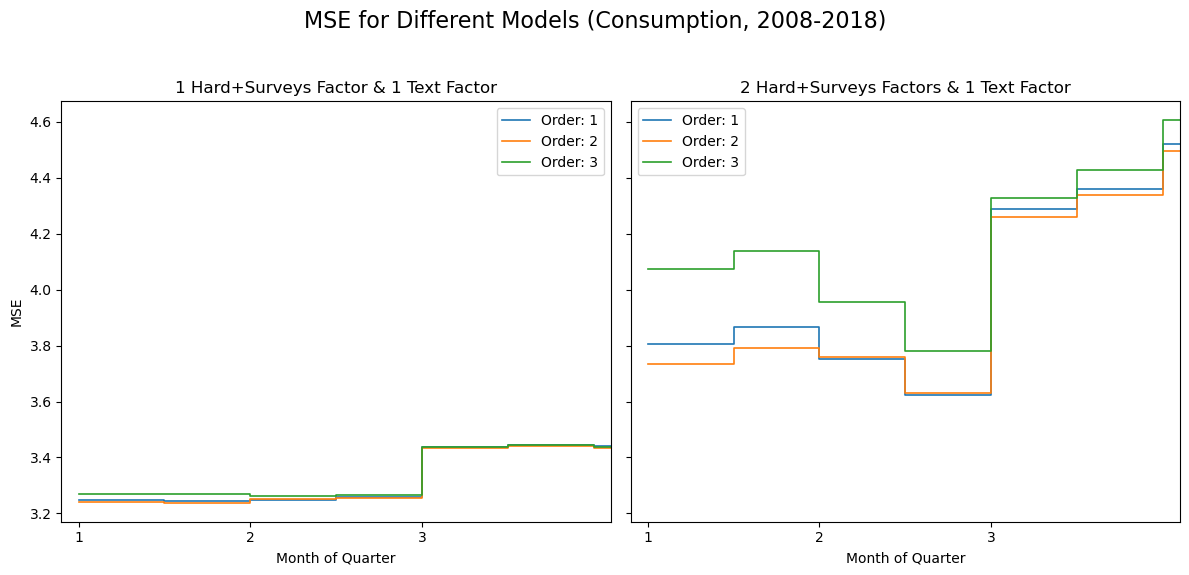

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


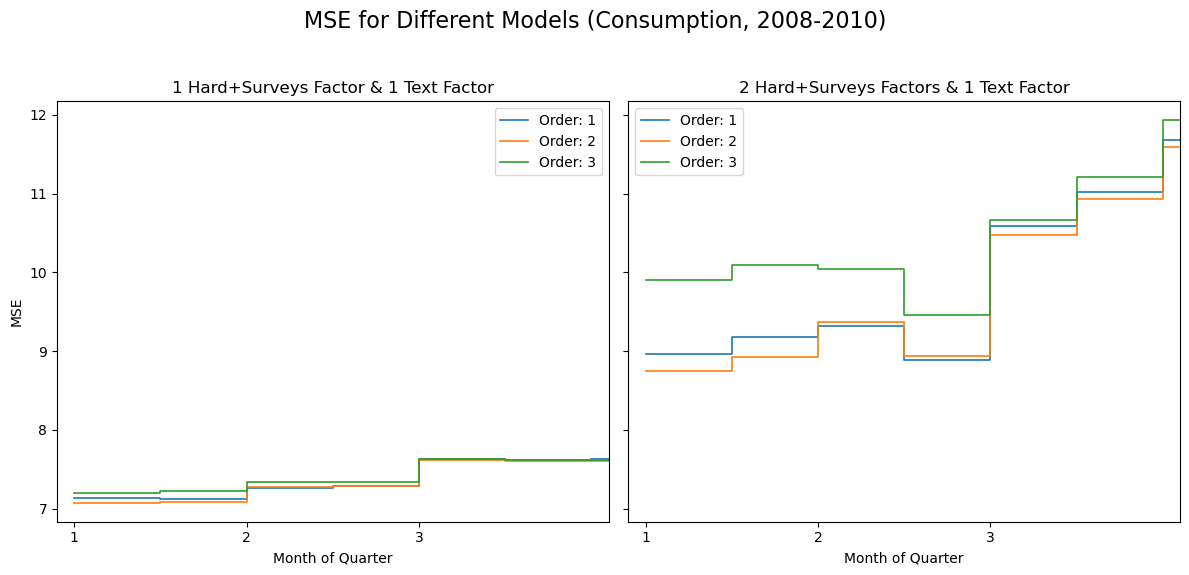

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


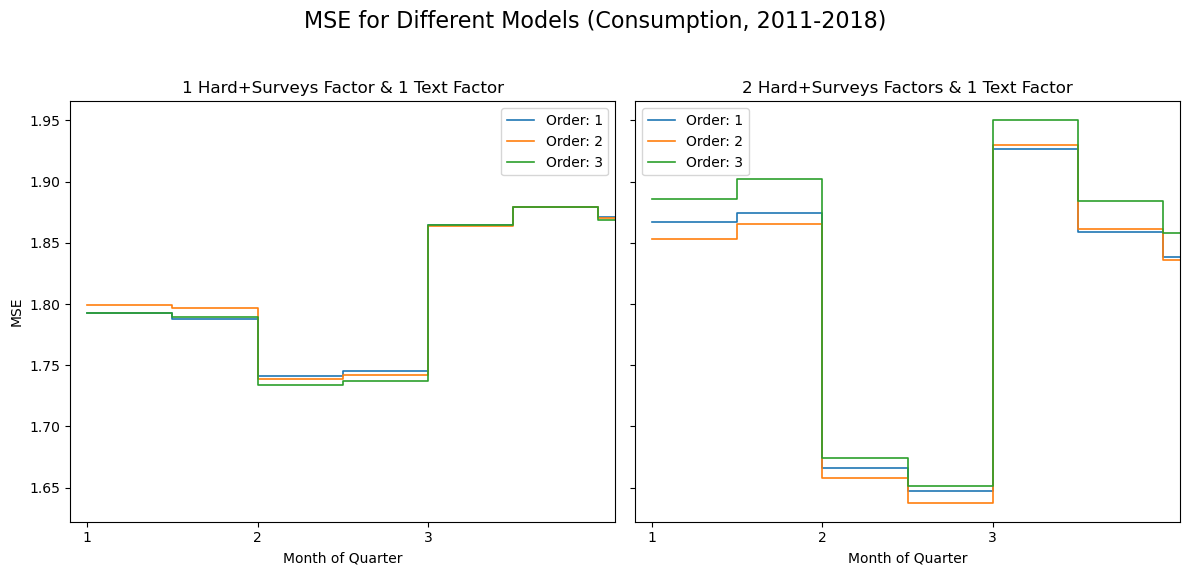

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


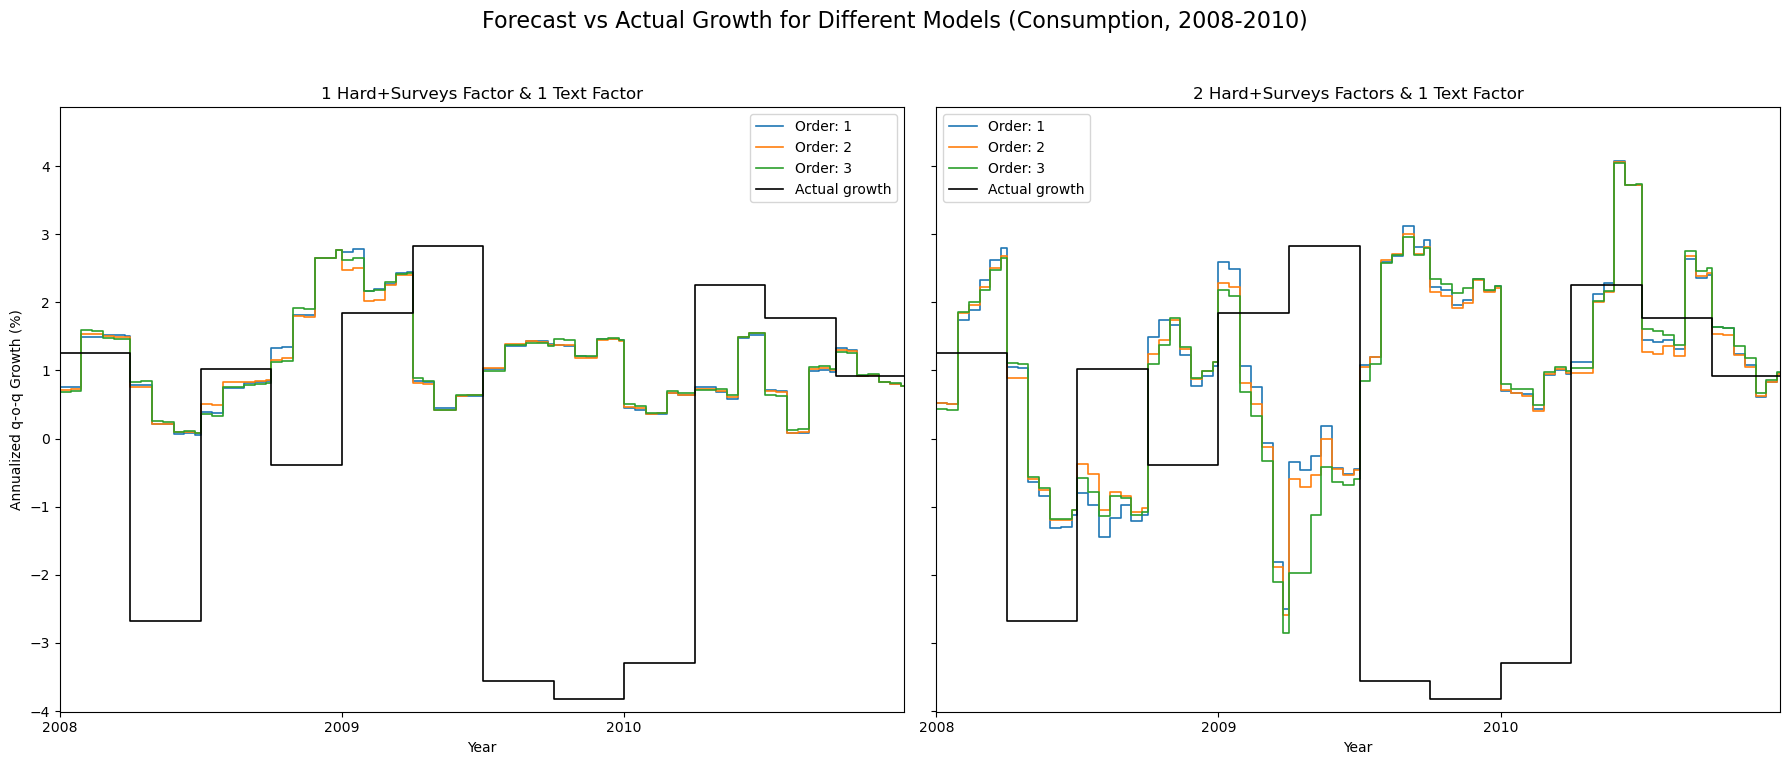

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


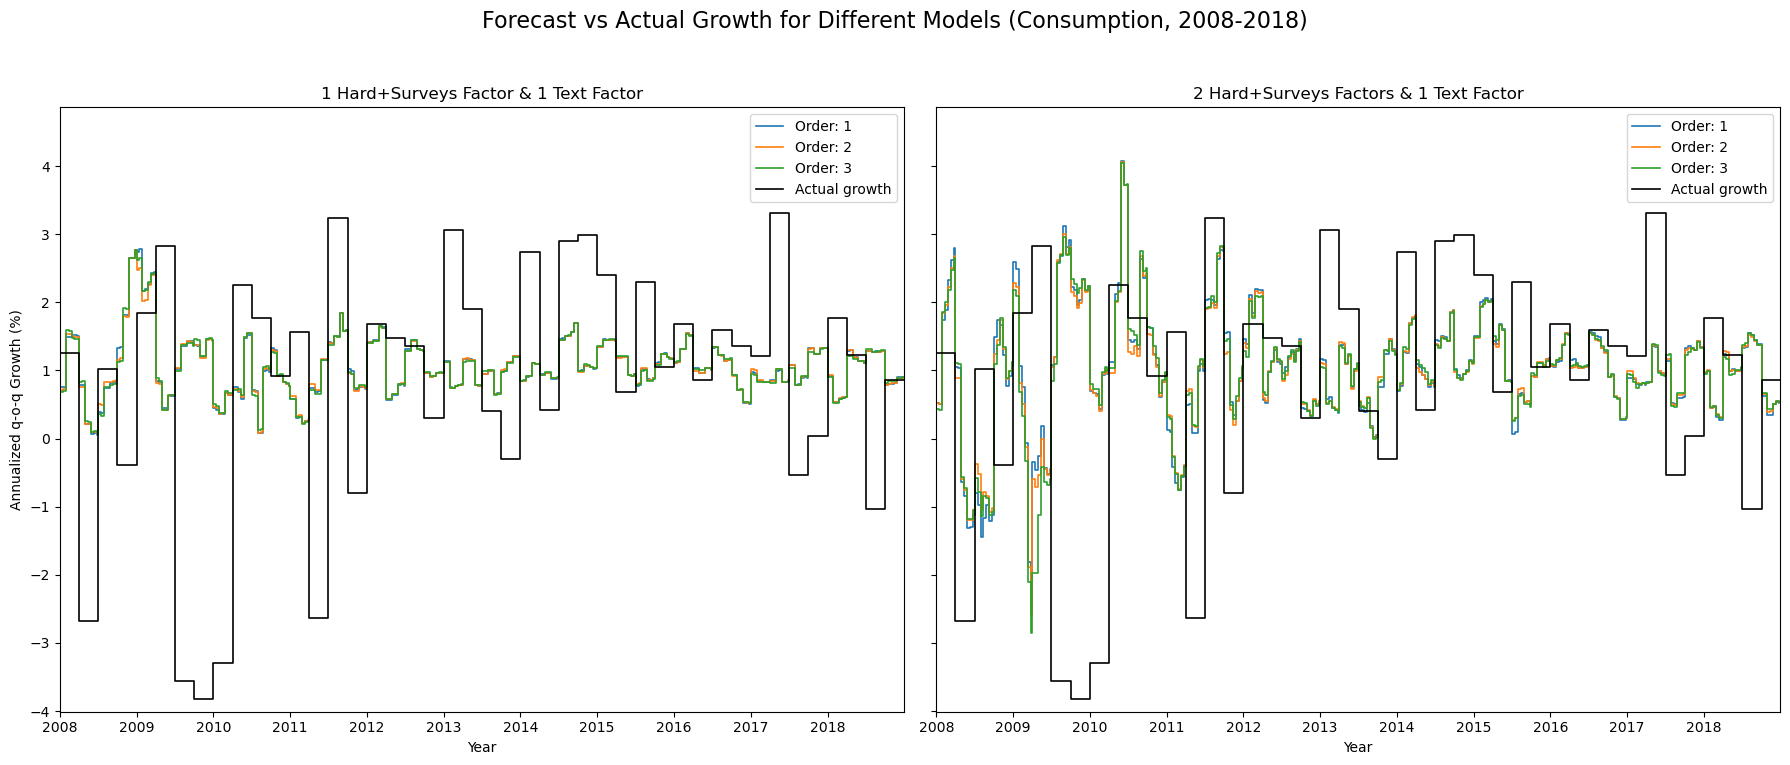

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


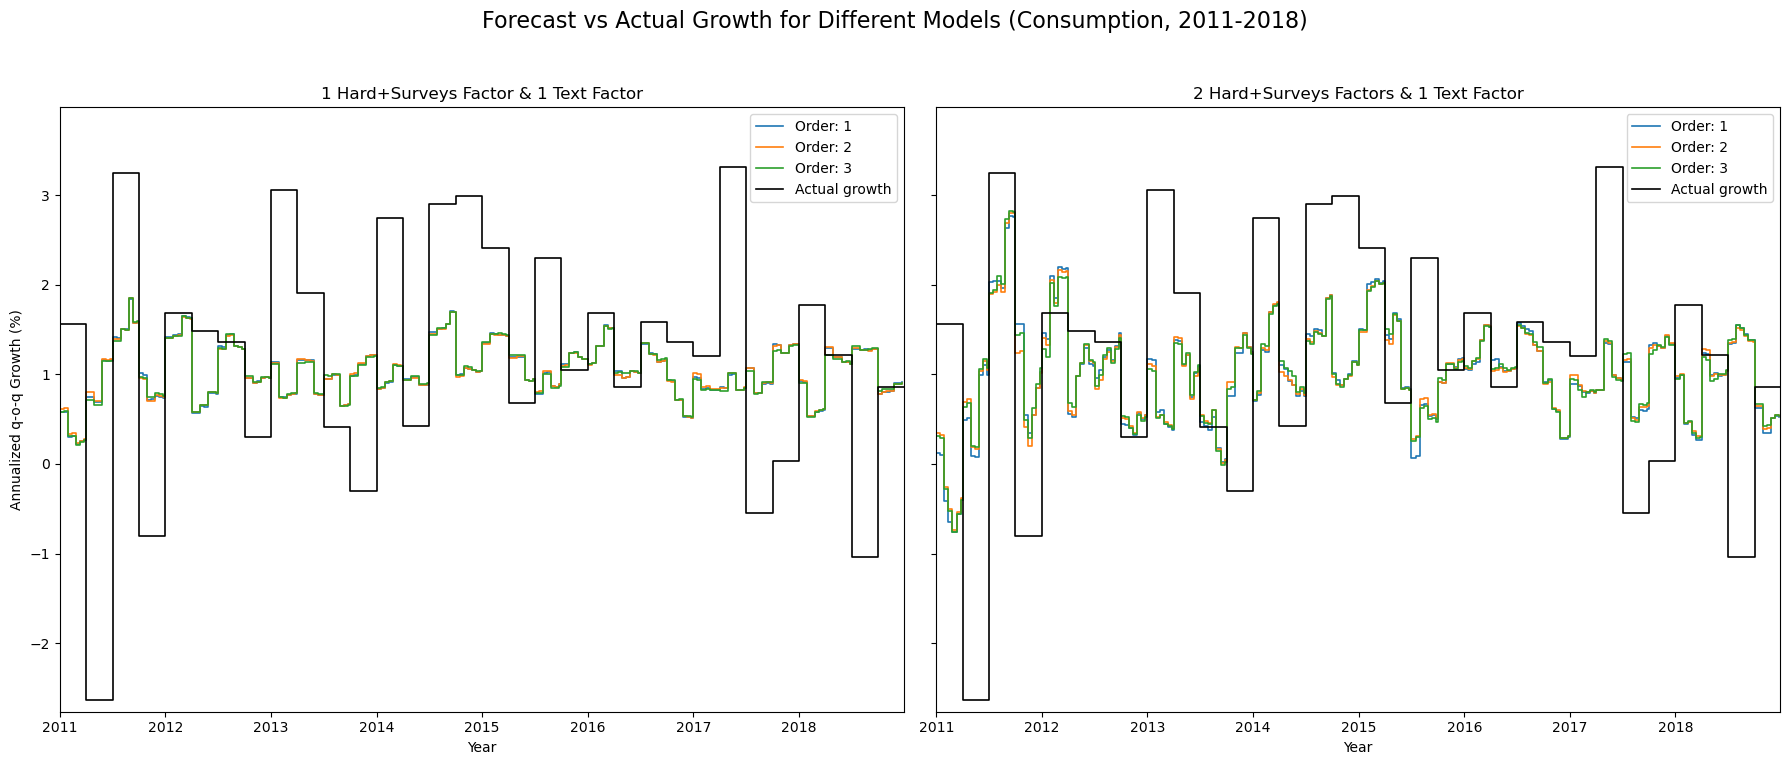

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()